# Supervised Sequence Regression

While the field of TCR-Seq has often put TCR's into antigenic categories (i.e. whether a TCR binds a given antigen), the true biology is the interaction of a TCR to an MHC-peptide is not a binary one but rather can be described by a continous value (i.e. affinity). We wanted to create an architecure that could train a given TCR sequence to a continuous value and not just a probability of yes/no. Instead, we will create a model here that predicts a proxy for binding affinity from a 10x Single Cell Dataset.

## Load Data

First, we will load the data for this analysis.

In [30]:
import pandas as pd
from DeepTCR.DeepTCR import DeepTCR_SS
import numpy as np
import os
import matplotlib.pyplot as plt

df = pd.read_csv('../../Data/10x_Data/Data_Regression.csv')

In [31]:
df.head()

,alpha,beta,A0101_VTEHDTLLY_IE-1_CMV,A0201_KTWGQYWQV_gp100_Cancer,A0201_ELAGIGILTV_MART-1_Cancer,A0201_CLLWSFQTSA_Tyrosinase_Cancer,A0201_IMDQVPFSV_gp100_Cancer,A0201_SLLMWITQV_NY-ESO-1_Cancer,A0201_KVAELVHFL_MAGE-A3_Cancer,A0201_KVLEYVIKV_MAGE-A1_Cancer,...,B0702_RPHERNGFTVL_pp65_CMV,B0801_RAKFKQLL_BZLF1_EBV,B0801_ELRRKMMYM_IE-1_CMV,B0801_FLRGRAYGL_EBNA-3A_EBV,A0101_SLEGGGLGY_NC,A0101_STEGGGLAY_NC,A0201_ALIAPVHAV_NC,A2402_AYSSAGASI_NC,B0702_GPAESAAGL_NC,NR(B0801)_AAKGRGAAL_NC
0,CAAAAGEAGTYKYIF,CASSLEEGYSPLHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CAAAANQAGTALIF,CASSFFVGGAEAFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CAAAASDGQKLLF,CASTLPGQKQFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CAAAAYNQGGKLIF,CATSDPAGMTGGWHGYTF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CAAADNYGQNFVF,CAWSSGEGTDTQYF,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, this dataset consists of an alpha/beta chain per TCR and recorded read count (which we will use as a proxy for binding affinity) to a given antigen (columns listed). We will train a sequence regression model on a well knnown flu epitope, 'A0201_GILGFVFTL_Flu-MP_Influenza'. We will extract alpha and beta chain and continuous values after log2 transformation.

In [32]:
alpha_sequences = np.array(df['alpha'])
beta_sequences = np.array(df['beta'])
Y = np.log2(np.array(df['A0201_GILGFVFTL_Flu-MP_Influenza'])+1)

Now we will load this data into a DeepTCR object and do a 5 fold cross-validation (as to not overfit) to obtain predicted affinities for all alpha/beta sequences to this peptide-MHC.

In [33]:
%%capture
DTCR = DeepTCR_SS('reg')
DTCR.Load_Data(alpha_sequences=alpha_sequences,beta_sequences=beta_sequences,Y=Y)
DTCR.K_Fold_CrossVal(folds=5)

INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


Once the training is complete, there are two ways to look at the result. Since we conducted a K-Fold Cross-Validation, the data was shuffled prior to doing the splits. In the case we had done a Monte-Carlo Cross-Validation, a similar procedure would be followed. The object variables DTCR.y_pred and DTCR.y_test contain the predicted and ground truth values in the order training was done, and not the order the data was provided to the DeepTCR object. So the first way to visualize this would be as follows:

First, we'll create a plotting function that uses a Guassian KDE to visualize the density of the distribution of the predicted vs ground truth affinities.

In [66]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
def Plot_Func(x,y):
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    r = np.argsort(z)
    x ,y, z = x[r], y[r], z[r]
    plt.figure()
    plt.scatter(x,y,s=15,c=z,cmap=plt.cm.jet)
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.xlabel('Predicted',fontsize=12)
    plt.ylabel('Log2(counts)',fontsize=12)

And now we will call our function to plot the predicted vs the actual affinity for each TCR sequences.

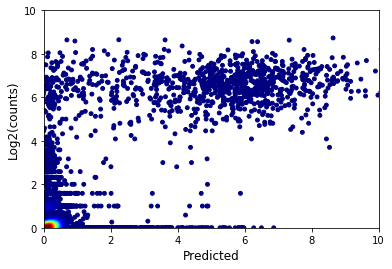

In [67]:
Plot_Func(np.squeeze(DTCR.y_pred),np.squeeze(DTCR.y_test))

As we can see, this method can be used to extract the TCR sequencees with both a high actual affinity and predicted affinty, serving as a way to filter out the highest likelihood sequences to bind this antigen.

Now, let's say we had trained with a Monte-Carlo approach..

In [68]:
%%capture
DTCR.Monte_Carlo_CrossVal(folds=5)

INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:reg/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


We can make the same plot as above with all the data that was used or we can instead made that plot for only the unique TCR entries. If we extract DTCR.predicted, we will get a vector in the same order of TCR's that were put into DeepTCR. These represent the average predicted value over all the cross-validations. The only thing to be weary of here is if a TCR sequence never ended up in the 'test' set of the MCs, it will have a prediction of 0.

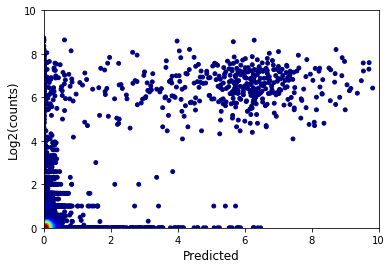

In [71]:
Plot_Func(np.squeeze(DTCR.predicted),Y)

As one can appreciate from these examples, we can create models that learn to regress a TCR to a continuous value.
Furthermore, we can look at the top predicted TCR's to look at their sequence structure for this antigen.

In [72]:
DTCR.Representative_Sequences(top_seq=25)

In [74]:
DTCR.Rep_Seq['High']

,alpha,beta,v_alpha,j_alpha,v_beta,d_beta,j_beta,Class,Regressed_Val,Sample,Freq,Counts,Predicted
37077,CAVNQGGGSQGNLIF,CASSIRSSEPQHF,None,None,None,None,None,None,6.240608,None,0.000017,1.0,11.172354
29334,CAVAKDLQNSGGGADGLTF,CASSIRASYEQYF,None,None,None,None,None,None,7.499846,None,0.000017,1.0,10.651810
14984,CAGTHGGSQGNLIF,CASSVRSTDTQYF,None,None,None,None,None,None,7.603626,None,0.000017,1.0,10.593774
11778,CAGAGGGSQGNLIF,CASSMRSADTQYF,None,None,None,None,None,None,6.807355,None,0.000017,1.0,10.269626
48705,CAYSPAAGGTSYGKLTF,CASSIRSSYEQYF,None,None,None,None,None,None,6.426265,None,0.000017,1.0,9.822449
12777,CAGGGQGGSQGNLIF,CASSIYSNQPQHF,None,None,None,None,None,None,7.595812,None,0.000017,1.0,9.716899
12739,CAGGGDGGSQGNLIF,CASSIRSTDTQYF,None,None,None,None,None,None,7.296457,None,0.000017,1.0,9.710082
37076,CAVNQGGGSQGNLIF,CASSIRSADTQYF,None,None,None,None,None,None,7.209453,None,0.000017,1.0,9.545546
12738,CAGGGDGGSQGNLIF,CASSIRSGVEQYF,None,None,None,None,None,None,7.579863,None,0.000017,1.0,9.539517
10650,CAFMKGAGGTSYGKLTF,CASSIGSYGYTF,None,None,None,None,None,None,6.765067,None,0.000017,1.0,9.483788
